# HOG + SVM 

---

## Motivacija

Histogram orijentisanih gradijenata predstavlja jedan pristup opisivanju karakteristika slike koji je dao odlične rezultate u oblasti detekcije objekata. HOG je invarijantan na promene osvetljenosti, senke, geometrijske transformacije i pomeraje objekata. Međutim, zavisan je od orijentacije objekta i parametara obučavanja, odsnosno veličine ćelija za koje se vrše izračunavanja.

Istorijski, pristup detekciji objekata putem HOG karakteristika dao je odlične rezultate u efikasnom i preciznom prepoznavanju ljudi na slikama. SVM klasifikator obučen je na osnovu karakteristika gradijenata pozitivnih i negativnih uzoraka, dok se multiscale detekcija vrši tako što se za svaki region vrši binarna klasifikacija na pozitivne i negativne uzorke.

---

## Postupak

<img alt="HOG znak" style="float: right;" src="images/im1.png" width="15%">

Kako bi se SVM obučio za klasifikaciju na pozitivne i negativne objekte, potrebno je napraviti dovoljno veliki skup pozitivnih i raznovrsnih negativnih slika. Zatim je potrebno takve slike obraditi, na osnovu zadatih parametara izračunati HOG karakteristike i izračunate karakteristike upotrebiti za obučavanje SVM.

HOG karakteristike izračunate su za svaku ulaznu sliku na osnovu OpenCV distribucije, uz sledeće parametre:
* veličina slike: 48x48
* veličina bloka: 4x4 i 8x8
* pomeraj bloka: 4 po obe ose
* veličina ćelije 4x4 i 8x8

Izračunati gradijenti zatim su serijalizovani i upotrebljeni za obučavanje klasifikatora. Upotrebljena je [SVM Light distribucija](http://svmlight.joachims.org/) kako bi se optimalno i brže došlo do prvih rezultata, uz efikasnu i brzu izvedbu SVM klasifikatora.

Rezultati SVM obrađeni su tako što se uzimaju vrednosti samih vektora i izračuna *bias term* funkcije odlučivanja, koji se doda na kraj niza. Takav niz se serijalizuje i predstavlja ulaz za sam detektor koji je baziran na SVM i HOG karakteristikama.

Multiscale detekcija se primenjuje kako bi se invarijantno od veličine prozora mogao potencijalno detektovati objekat.

Obučeno je onoliko klasifikatora koliko ima vrsta znakova, po njihovom geometrijskom obliku:
* šestougao
* krug
* kvadrat
* trougao uspravni
* trougao obrnuti

#### Primer 1

Prvi primer upotrebljava blokove veličine 4x4 i ćelije veličine 4x4. Ispitivaće se klasifikator koji je obučavan za stop znakove. Pomoćne funkcije i potrebne konstante definisane su za buduće primere radi lakše upotrebe i modifikacije parametara.

Parametri multiscale detekcije poput granice pogotka, skaliranja, pomeraja prozora za detekciju i piksela okoline koji se dodaju regionu dodatno se mogu podešavati kako bi se ostvario bolji rezultat.

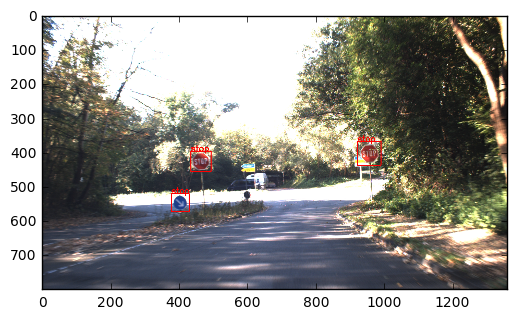

In [19]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

WIN_SIZE = (48,48)
BLOCK_SIZE = (4,4)
BLOCK_STRIDE = (4,4)
CELL_SIZE = (4,4)
NBINS = 9
DERIV_APERTURE = 1
WIN_SIGMA = -1

HIT_THRESHOLD = 0.6
SCALE = 1.02
WIN_STRIDE = (4,4)
PADDING = (10,10)

SVM_PATH = 'models/Classifiers/'
STOP = 'stop.vec'
ROUND = 'round.vec'
TRIANGLE_UP = 'triangle_up.vec'
TRIANGLE_DOWN = 'triangle_down.vec'
SQUARE_ROT = 'square_rot.vec'

IMG_PATH = 'images/'
FILES = ['00074.png','00115.png','00140.png','00177.png','00193.png','00198.png','00200.png','00202.png','00340.png','00789.png','00809.png','00827.png']

def read_svm_descriptor(path):

    f = open(path, 'r')
    line = f.readline()

    l = []

    for el in line.split():
        l.append(float(el))
        
    return l
    

def hog_detector_setup(SVM_FILE):
    hog = cv2.HOGDescriptor(WIN_SIZE, BLOCK_SIZE, BLOCK_STRIDE, 
                            CELL_SIZE, NBINS, DERIV_APERTURE, WIN_SIGMA)
    
    svm = np.array(read_svm_descriptor(SVM_PATH+SVM_FILE))
    
    hog.setSVMDetector(svm)
    
    return hog
    
def detect_and_mark(img, hog, color, text):
    (boxes, weights) = hog.detectMultiScale(img, HIT_THRESHOLD, WIN_STRIDE, PADDING, SCALE)
    
    for (x, y, w, h) in boxes:
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img, text, (x,y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color,2)
    
        
def test_image_all(image_path, stp, rnd, tru, trd, sqr):

    img = cv2.imread(image_path)
    
    detect_and_mark(img, stp, (0,0,255), "stop")
    detect_and_mark(img, rnd, (255,0,0), "round")
    detect_and_mark(img, tru, (0,255,0), "triangle_up")
    detect_and_mark(img, trd, (0,255,255), "triangle_down")
    detect_and_mark(img, sqr, (255,255,0), "square")
        
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.show()

def test_image(image_path, hog, color, text):
    img = cv2.imread(image_path)
    
    detect_and_mark(img, stp, color, text)
        
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.show()
    
stp = hog_detector_setup(STOP)
rnd = hog_detector_setup(ROUND)
tru = hog_detector_setup(TRIANGLE_UP) 
trd = hog_detector_setup(TRIANGLE_DOWN)
sqr = hog_detector_setup(SQUARE_ROT)

test_image(IMG_PATH+FILES[0], stp, (0,0,255), "stop")

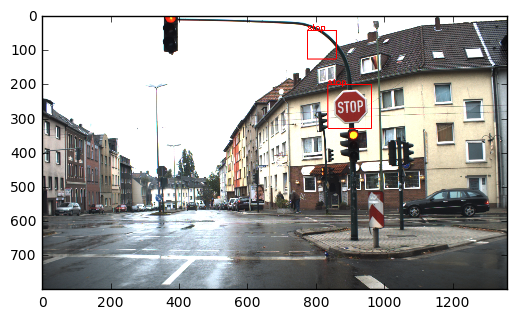

In [20]:
test_image(IMG_PATH+FILES[1], stp, (0,0,255), "stop")

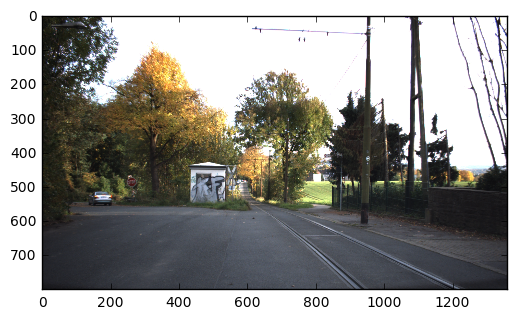

In [9]:
test_image(IMG_PATH+FILES[2], stp, (0,0,255), "stop")

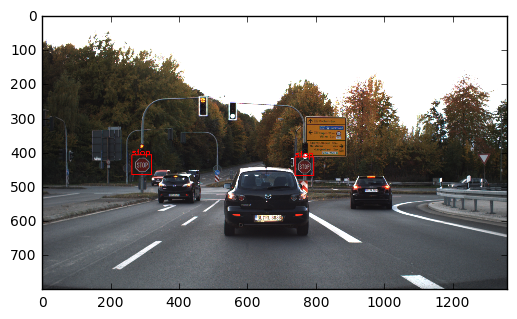

In [10]:
test_image(IMG_PATH+FILES[3], stp, (0,0,255), "stop")

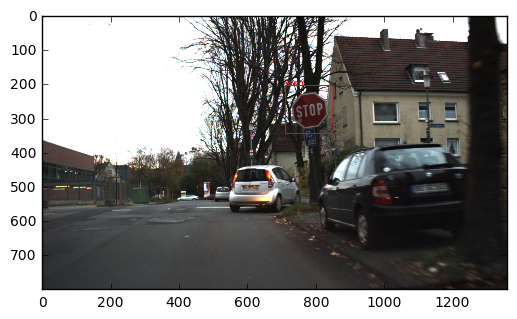

In [11]:
test_image(IMG_PATH+FILES[4], stp, (0,0,255), "stop")

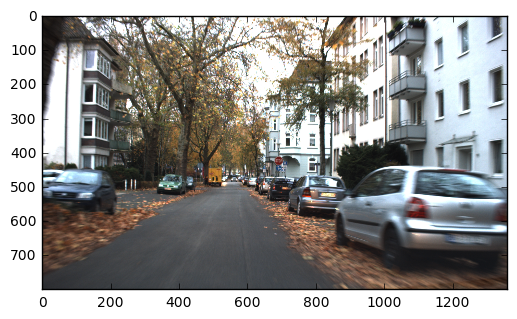

In [30]:
test_image(IMG_PATH+FILES[5], stp, (0,0,255), "stop")

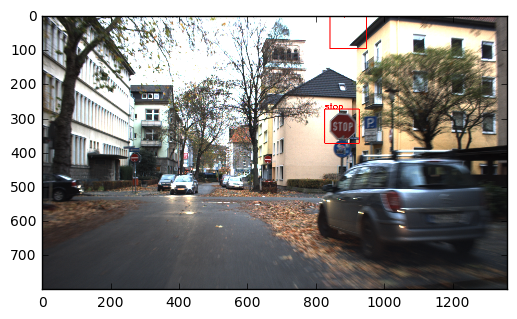

In [13]:
test_image(IMG_PATH+FILES[6], stp, (0,0,255), "stop")

U prethodnim primerima moguće je uočiti da su znakovi, ukoliko nisu premali na sceni, detektovani. Međutim, javljaju se lažno detektovani objekti. Ovo ukazuje na potrebu da se u skup za obučavanje uključe takvi elementi scene koji izazivaju lažne pogotke kako bi se revidiralo pogrešno naučeno klasifikovanje.

#### Primer 2

U ovom primeru je klasifikator obučen sa parametrima veličine bloka 8x8, a veličine ćelije 8x8. Ostali parametri identični su prethodno obučenim SVM klasifikatorom u smislu HOG karakteristika slike.

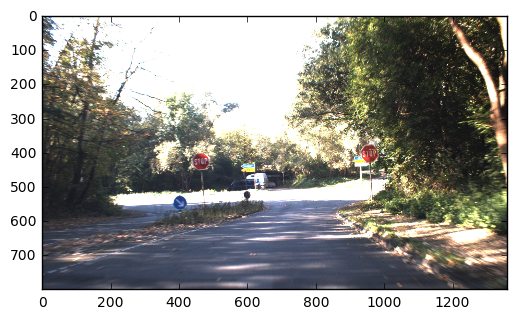

In [21]:
WIN_SIZE = (48,48)
BLOCK_SIZE = (8,8)
BLOCK_STRIDE = (4,4)
CELL_SIZE = (8,8)
NBINS = 9
DERIV_APERTURE = 1
WIN_SIGMA = -1

SVM_PATH = 'models/'

stp = hog_detector_setup(STOP)
rnd = hog_detector_setup(ROUND)
tru = hog_detector_setup(TRIANGLE_UP) 
trd = hog_detector_setup(TRIANGLE_DOWN)
sqr = hog_detector_setup(SQUARE_ROT)

test_image(IMG_PATH+FILES[0], stp, (0,0,255), "stop")

Ukoliko su parametri samog detektora isti, moguće je uočiti da se objekti nisu detektovali. Potrebno je u zavisnosti od parametara izračunavanja HOG karakteristika utvrditi koji će parametri da doprinesu najuspešnijoj detekciji. Ovi parametri se empirijski određuju, međutim moguće je uvesti i elemente računarske inteligencije, uz napomenu da je potrebna sigurnost u obučeni klasifikator, jer ukoliko se unos sa bilo kakvim parametrima dovede na nepouzdan klasifikator, izlaz će biti u istoj ili većoj meri nepouzdan. Izvršiće se modifikacija parametara granice pogotka, stepena skaliranja i dodavanja piksela prozoru za detekciju, s obzirom na to da se radi o mnogo detaljnijim HOG karakteristikama sa manjom veličinom bloka i ćelije.

Može se zaključiti da je detektor sa istim skupom za obučavanje, ali sa preciznijim karakteristikama mnogo pouzdaniji i da su uklonjeni lažno detektovani objekti.

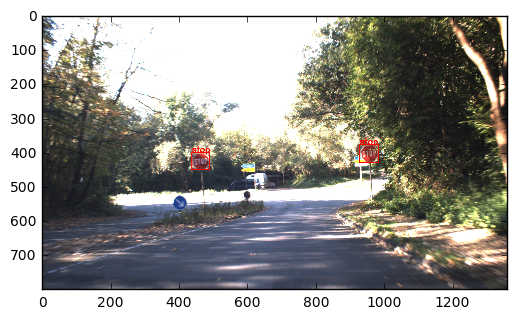

In [39]:
HIT_THRESHOLD = 0
SCALE = 1.05
WIN_STRIDE = (4,4)
PADDING = (10,10)

test_image(IMG_PATH+FILES[0], stp, (0,0,255), "stop")

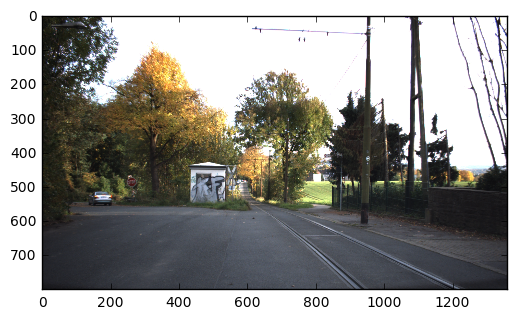

In [41]:
test_image(IMG_PATH+FILES[2], stp, (0,0,255), "stop")

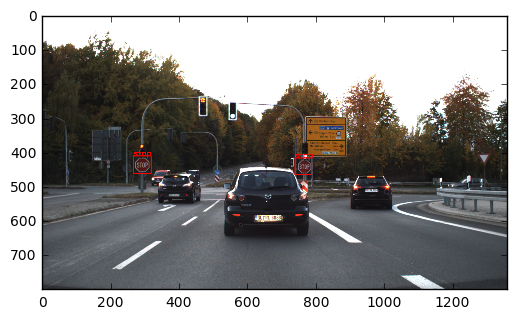

In [40]:
test_image(IMG_PATH+FILES[3], stp, (0,0,255), "stop")

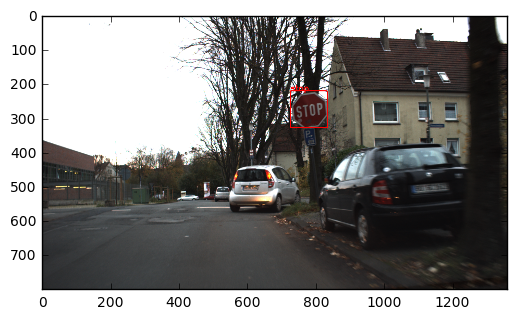

In [42]:
test_image(IMG_PATH+FILES[4], stp, (0,0,255), "stop")

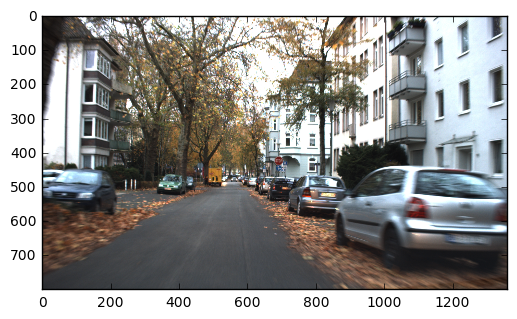

In [43]:
test_image(IMG_PATH+FILES[5], stp, (0,0,255), "stop")

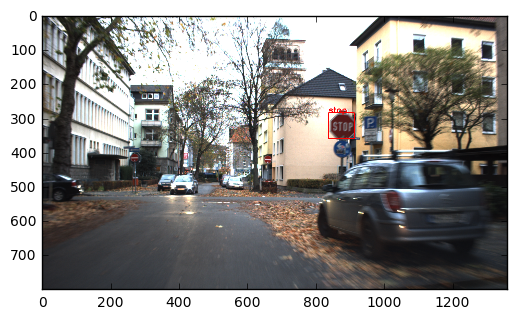

In [44]:
test_image(IMG_PATH+FILES[6], stp, (0,0,255), "stop")

#### Primer 3

Moguća su dva pristupa detekciji znakova: obučavanje velikog klasifikatora gde su pozitivni primeri svi saobraćajni znakovi, gde se efektivno obučava detektor. Moguće je obučiti i ansambl detektora za svaki znak, međutim, performanse su niže u zavisnosti od broja neophodnih iteracija u detekciji, koje direktno zavise od broja klasifikatora. Međutim, u ovom slučaju se dobija i detektor i klasifikator samih znakova.

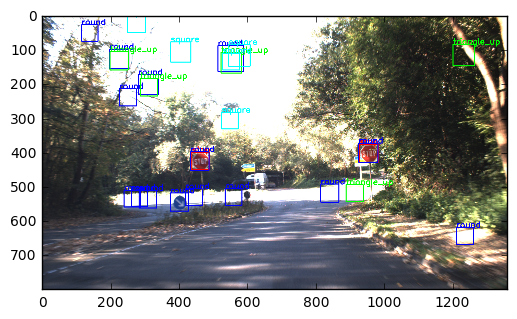

In [48]:
test_image_all(IMG_PATH+FILES[0], stp, rnd, tru, trd, sqr)

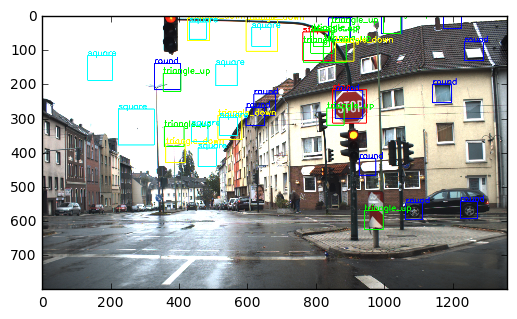

In [49]:
test_image_all(IMG_PATH+FILES[1], stp, rnd, tru, trd, sqr)

Pored lošijih performansi po pitanju brzine obrade, moguće je zaključiti da ostali klasifikatori imaju poteškoća sa lažnom detekcijom. S obzirom na to da se radi o oblicima koji su češći od šestougla: kruga, kvadrata, i različito orijentisanih trouglova, zaključak je da je više pažnje neophodno posvetiti nalaženju negativnih uzoraka kako bi se sprečila detekcija koja ne predstavlja objekat od interesa.